In [1]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()


def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [2]:
import csv
import numpy as np
from IPython.display import Image, HTML, clear_output
import matplotlib.pyplot as plt


In [4]:
#@title load data
with open('torus_48x14x48.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
SIZE_X=48
SIZE_Y=14
SIZE_Z=48

numpy_array = np.array(data)
numpy_array = np.array(data[1:])
arr=numpy_array[...,:3].astype(float)
#for a in arr:
  #print (a[0],a[1])


In [5]:
#@title layer of z
def return_zLayer(arr,z):
    z= np.array([arr[arr[:, -1] ==  z]])
    Zxy=z[0][...,:2].astype(int)
    Z=np.zeros((SIZE_X,SIZE_Y))
    
    for i in Zxy:
        Z[i[0]][i[1]]=1
    import matplotlib.pyplot as plt
    plt.imshow(Z, cmap="binary")
    plt.axis("off")
    plt.show()
    return Z

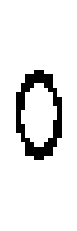

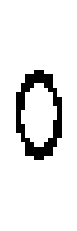

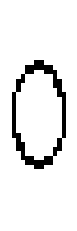

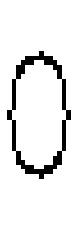

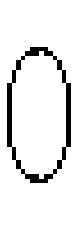

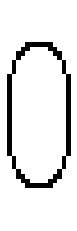

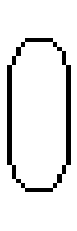

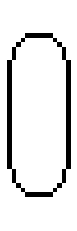

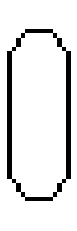

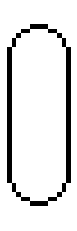

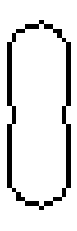

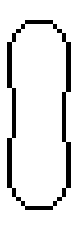

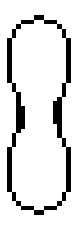

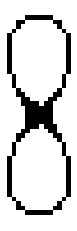

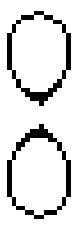

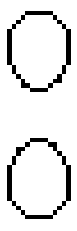

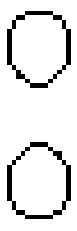

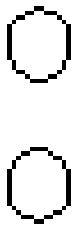

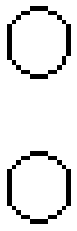

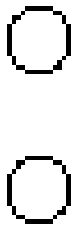

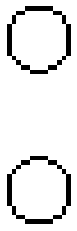

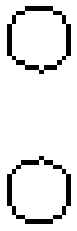

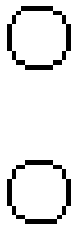

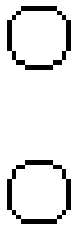

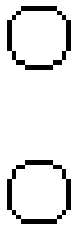

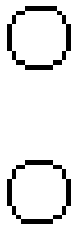

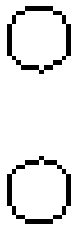

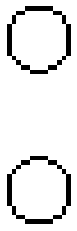

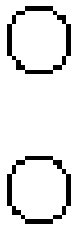

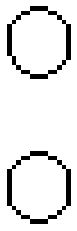

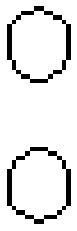

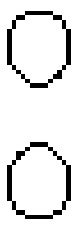

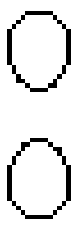

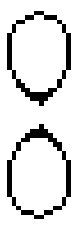

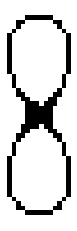

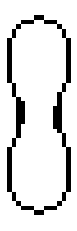

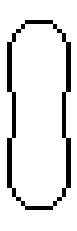

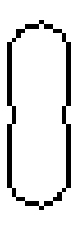

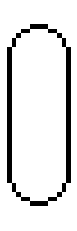

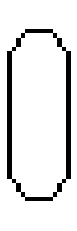

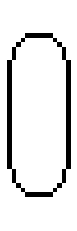

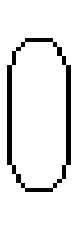

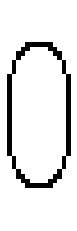

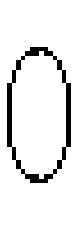

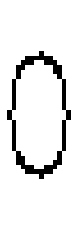

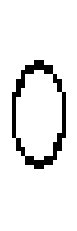

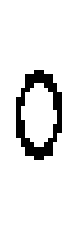

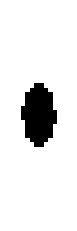

(48, 14, 48)


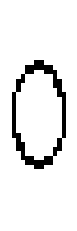

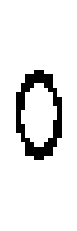

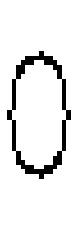

(48, 14)


In [6]:
#@title creating array by stacking up x,y of all g
z_stack=return_zLayer(arr,1)
for i in range(1,SIZE_Z):
  x=return_zLayer(arr,i)
  z_stack = np.dstack((z_stack,x))
print(z_stack.shape)
target_img=np.array(return_zLayer(arr,2))
channel1=np.array(return_zLayer(arr,1))
channel2=np.array(return_zLayer(arr,3))
print(target_img.shape)

In [8]:
#@title defing seed
Channel=4
seed = np.zeros([1,SIZE_X,SIZE_Y,Channel],np.float32)
seed[:,SIZE_X//2,SIZE_Y//2,Channel//2]=1
print(seed.shape)
print(seed[0].shape)
#print(seed[0][...,0])

(1, 48, 14, 4)
(48, 14, 4)


In [11]:
#@title Building Model  1
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D
from keras.layers import Conv3D
from keras.models import Sequential, load_model

class CA(tf.Module):
  def __init__(self):
    self.model=tf.keras.Sequential([
        Conv3D(128,3,padding='same',activation=tf.nn.relu), # models perception of the cell & projects 3x3 neighbourhood of each cell into 128 dimentional vector
        Conv3D(Channel,1,kernel_initializer=tf.zeros) # this layer computes independent part cell update vector that is being incrementally added to current state of each cell
        # we use incremental updates being inspirede by residual network & euler intrigration
        # here kernel_initializer=tf.zero because not initializing generates random pattern that makes it hard for the model to look like target image
    ])
  
  @tf.function
  def __call__(self,x):
    return x+self.model(x)

#our model is made out of convolution models only, exploiting thr close relationship between convolutions and cellular automata
# Convolution are cellular automata that restrict the opertaion they perform to the linear function of cells neighbourhood

In [12]:
#@title Running randomly initialized CA for some ittirations{vertical-output:true}
ca=CA()
x=seed
ittiration=100
with VideoWriter("x.mp4")as vid:
  for i in range(ittiration):
    vid.add(zoom(to_rgb(x[0])))
    x=ca(x)
mvp.ipython_display('x.mp4')

ValueError: ignored

In [ ]:
#@title Loss function
training=tf.optimizers.Adam(1e-3)
loss_log=[]

@tf.function
def training_step():
  with tf.GradientTape() as g:
    x=seed
    ittiration =100
    for i in range(ittiration):
      x=ca(x)
      loss= tf.reduce_mean(tf.square(x[0][...,1]-target_img)+(tf.square(x[0][...,0]-channel1))+(tf.square(x[0][...,2]-channel2)))
      sum_diff=0
     # for  i in range(SIZE_Z):
        #tf.square(x[0][...,1]-target_img
      #loss= tf.reduce_mean(tf.square((x[...,:4][...,0][0]*mask)-(target_img[...,0][0]*mask)))
  params=ca.trainable_variables
  grads=g.gradient(loss, params) 
  training.apply_gradients(zip(grads,params))
  return loss,x

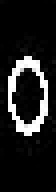

chanel1


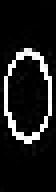

main


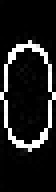

chanel2


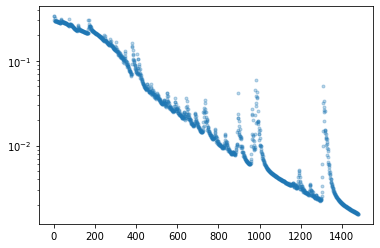

480 0.0015666414


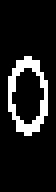

c1


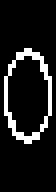

taregt main


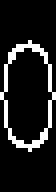

c2


In [ ]:
#@title Training loop {vertical-output:true}
with VideoWriter("x.mp4")as vid:

  for i in range(500):#looking at loss for 500 ittirations
    
    #vid.add(zoom(x[0]))
    loss,x=training_step()
    
    loss_log.append(loss.numpy())
    if i%20==0:
      clear_output(True)
      xx=x[0][...,0]
      imshow(zoom(xx))
      print('chanel1')
      xx=x[0][...,1]
      imshow(zoom(xx))
      print('main')
      xx=x[0][...,2]
      imshow(zoom(xx))
      print('chanel2')
      pl.plot(loss_log,'.',alpha=0.3)
      pl.yscale('log')
      pl.show()
      print(i,loss.numpy(),flush=True)

  #looking at the grid during the final states of evolution
stage_1_seed=x

imshow(zoom(channel1))
print('c1')
imshow(zoom(target_img))
print('taregt main')
imshow(zoom(channel2))
print('c2')
mvp.ipython_display('x.mp4')

In [ ]:
import cv2
import numpy as np

# Create a NumPy array with zeros and ones
data =x
data = 255 * data
# Convert the NumPy array to an image
img = cv2.imwrite('image.png', data)

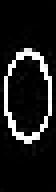

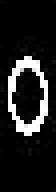

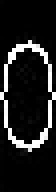

In [ ]:
x=seed
ittiration=100
for i in range(ittiration):
  x=ca(x)
  clear_output(True)
  xx=x[0][...,1]
  imshow(zoom(xx))
  xx=x[0][...,0]
  imshow(zoom(xx))
  xx=x[0][...,2]
  imshow(zoom(xx))


In [ ]:
#@title ignore now
target = PIL.Image.open("image.png")
#target=target.resize((SIZE_X,SIZE_Y))

target_img=np.float32(target)/255.0
alpha=target_img
imshow(target_img)
print(target_img.shape)